In [1]:
# Install the following dependencies to run this example notebook:
# xarray[complete] requests aiohttp geopandas xvec
from datetime import datetime, timedelta, timezone

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import xarray as xr
import xvec

In [2]:
# Open the dynamical.org GEFS forecast dataset
# Dataset documentation: https://dynamical.org/catalog/noaa-gefs-forecast-35-day

gefs_ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", decode_timedelta=True, chunks=None)
gefs_ds

<xarray.Dataset> Size: 812TB
Dimensions:                                         (init_time: 1618,
                                                     ensemble_member: 31,
                                                     lead_time: 181,
                                                     latitude: 721,
                                                     longitude: 1440)
Coordinates:
  * ensemble_member                                 (ensemble_member) uint16 62B ...
    expected_forecast_length                        (init_time) timedelta64[ns] 13kB ...
    ingested_forecast_length                        (init_time, ensemble_member) timedelta64[ns] 401kB ...
  * init_time                                       (init_time) datetime64[ns] 13kB ...
  * latitude                                        (latitude) float64 6kB 90...
  * lead_time                                       (lead_time) timedelta64[ns] 1kB ...
  * longitude                                       (longitude) float64 12kB ...
    spatial_ref                                     int64 8B ...
    valid_time                                      (init_time, lead_time) datetime64[ns] 2MB ...
Data variables: (12/38)
    categorical_freezing_rain_surface               (init_time, ensemble_member, lead_time, latitude, longitude) float32 38TB ...
    categorical_freezing_rain_surface_avg           (init_time, lead_time, latitude, longitude) float32 1TB ...
    categorical_ice_pellets_surface                 (init_time, ensemble_member, lead_time, latitude, longitude) float32 38TB ...
    categorical_ice_pellets_surface_avg             (init_time, lead_time, latitude, longitude) float32 1TB ...
    categorical_rain_surface                        (init_time, ensemble_member, lead_time, latitude, longitude) float32 38TB ...
    categorical_rain_surface_avg                    (init_time, lead_time, latitude, longitude) float32 1TB ...
    ...                                              ...
    wind_u_100m                                     (init_time, ensemble_member, lead_time, latitude, longitude) float32 38TB ...
    wind_u_10m                                      (init_time, ensemble_member, lead_time, latitude, longitude) float32 38TB ...
    wind_u_10m_avg                                  (init_time, lead_time, latitude, longitude) float32 1TB ...
    wind_v_100m                                     (init_time, ensemble_member, lead_time, latitude, longitude) float32 38TB ...
    wind_v_10m                                      (init_time, ensemble_member, lead_time, latitude, longitude) float32 38TB ...
    wind_v_10m_avg                                  (init_time, lead_time, latitude, longitude) float32 1TB ...
Attributes:
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    spatial_resolution:   0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0...
    time_domain:          Forecasts initialized 2020-10-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 24 hours.
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...

## Single station analysis
Lets start by using the NOAA weather station API and the dynamical.org GEFS zarr dataset to 
compare forecasts and observations at a single site.

In [3]:
# Retrieve weather station information from api.weather.gov
station_id = "KDFW" # Dallas/Fort Worth International Airport
station_info = requests.get(f"https://api.weather.gov/stations/{station_id}").json()
station_lon, station_lat = station_info["geometry"]["coordinates"]

In [4]:
# Retrieve recent observations from the selected weather station
end_time = datetime.now(timezone.utc)
start_time = end_time - timedelta(days=7)
start_time_utc = start_time.replace(tzinfo=None)  # xarray doesn't love time zone aware dates unfortunately

station_observations_response = requests.get(
    f"https://api.weather.gov/stations/{station_id}/observations", 
    params={"start": start_time.isoformat(), "end": end_time.isoformat()}
)

observations = [obs["properties"] for obs in station_observations_response.json()["features"]]

timestamps = [obs["timestamp"] for obs in observations]
values = [{key: obs[key]["value"] for key in obs if isinstance(obs[key], dict)} for obs in observations]

station_df = pd.DataFrame(values, index=pd.DatetimeIndex(timestamps), dtype=float).sort_index()
station_df

,elevation,temperature,dewpoint,windDirection,windSpeed,windGust,barometricPressure,seaLevelPressure,visibility,maxTemperatureLast24Hours,minTemperatureLast24Hours,precipitationLastHour,precipitationLast3Hours,precipitationLast6Hours,relativeHumidity,windChill,heatIndex
2025-02-28 04:53:00+00:00,182.0,13.3,-0.6,0.0,0.00,NaN,102240.0,102210.0,16090.0,NaN,NaN,NaN,NaN,NaN,38.362938,NaN,NaN
2025-02-28 05:53:00+00:00,182.0,10.6,0.0,200.0,5.40,NaN,102240.0,102200.0,16090.0,NaN,NaN,NaN,NaN,NaN,47.875061,NaN,NaN
2025-02-28 06:53:00+00:00,182.0,9.4,0.0,250.0,5.40,NaN,102200.0,102160.0,16090.0,NaN,NaN,NaN,NaN,NaN,51.877005,8.964529,NaN
2025-02-28 07:53:00+00:00,182.0,8.9,1.1,330.0,5.40,NaN,102170.0,102130.0,16090.0,NaN,NaN,NaN,NaN,NaN,58.088233,8.394346,NaN
2025-02-28 08:53:00+00:00,182.0,7.2,0.6,210.0,9.36,NaN,102070.0,102030.0,16090.0,NaN,NaN,NaN,NaN,NaN,62.894657,5.430358,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-06 22:53:00+00:00,182.0,17.8,-1.1,150.0,24.12,NaN,101080.0,101050.0,16090.0,NaN,NaN,NaN,NaN,NaN,27.723706,NaN,NaN
2025-03-07 00:53:00+00:00,182.0,16.7,-0.6,150.0,16.56,NaN,100980.0,100950.0,16090.0,NaN,NaN,NaN,NaN,NaN,30.825758,NaN,NaN
2025-03-07 01:53:00+00:00,182.0,16.1,0.0,140.0,20.52,NaN,100950.0,100910.0,16090.0,NaN,NaN,NaN,NaN,NaN,33.453418,NaN,NaN
2025-03-07 02:53:00+00:00,182.0,15.0,1.1,150.0,14.76,NaN,100980.0,100950.0,16090.0,NaN,NaN,NaN,NaN,NaN,38.862553,NaN,NaN


/home/alden/code/dynamical/notebooks/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


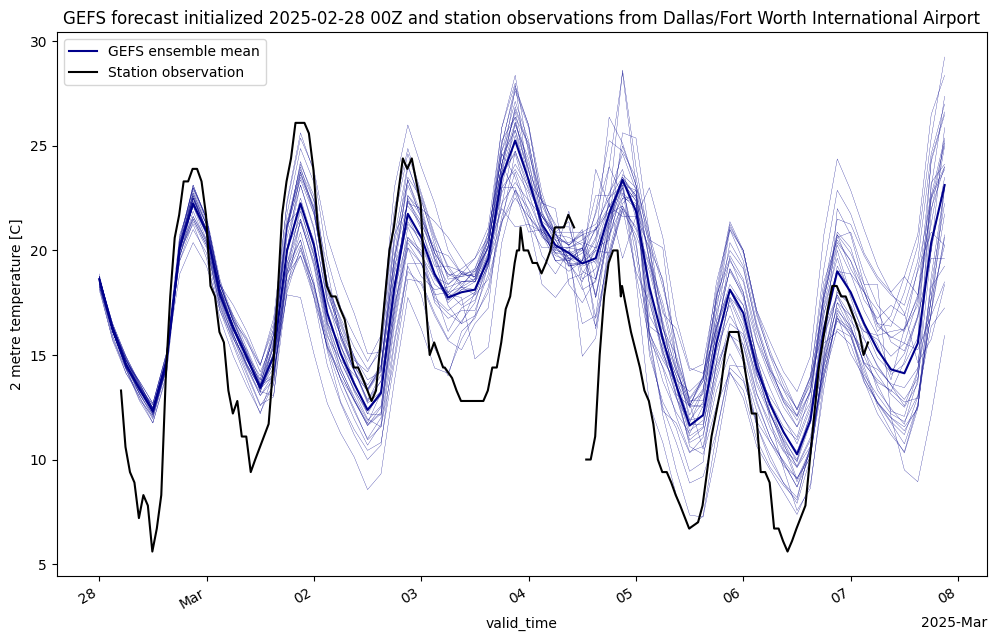

In [5]:
# Plot a GEFS forecast and recent station observations
plot_ds = gefs_ds.sel(
    init_time=start_time_utc,
    longitude=station_lon,
    latitude=station_lat,
    method="nearest"
).sel(lead_time=slice("0h", "7d"))

figure, axes = plt.subplots(figsize=(12, 8))

plot_ds["temperature_2m"].plot(x="valid_time", hue="ensemble_member", c="darkblue", linewidth=0.2, ax=axes)
plot_ds["temperature_2m_avg"].plot(x="valid_time", c="darkblue", label="GEFS ensemble mean", ax=axes)

station_df["temperature"].plot(c="black", label="Station observation", ax=axes)

axes.set_title(f"GEFS forecast initialized {plot_ds.init_time.dt.strftime('%Y-%m-%d %HZ').item()} "
               f"and station observations from {station_info['properties']['name']}")
axes.legend()

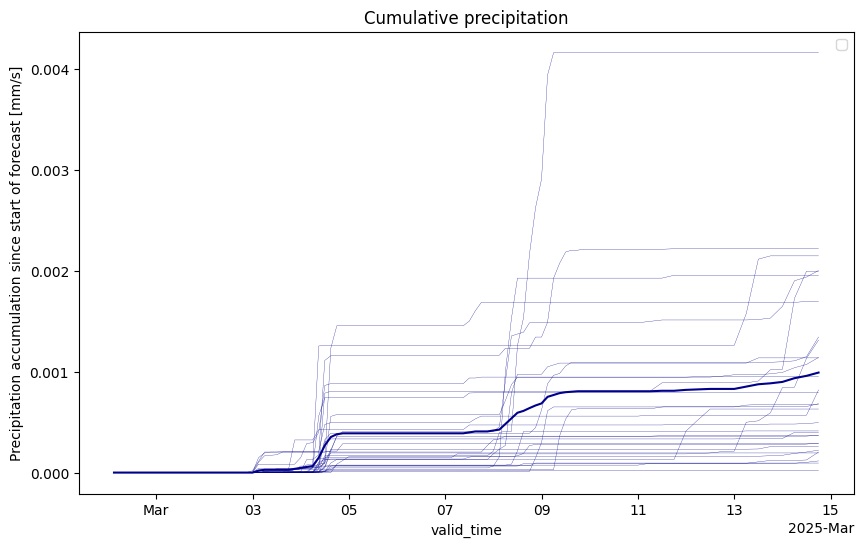

In [ ]:
# Plot the cumulative precipitation since the start of the forecast

# Select the initialization, location, and range of lead times
plot_ds = gefs_ds[["precipitation_surface", "precipitation_surface_avg"]].sel(
    init_time=start_time_utc,
    longitude=station_lon,
    latitude=station_lat,
    method="nearest"
).sel(lead_time=slice("0h", "14d"))

# Cumulative sum to calculate the accumulation since the start of the forecast.

cumulative_plot_ds = plot_ds.cumulative(dim="lead_time").sum()
# Add back coordinates that we loose during the cumulative sum (xarray can't be sure they are still correct)
cumulative_plot_ds = cumulative_plot_ds.assign_coords(valid_time=plot_ds.valid_time, lead_time=plot_ds.lead_time) 

cumulative_plot_ds["precipitation_surface"].plot(x="valid_time", hue="ensemble_member", c="darkblue", linewidth=0.2, figsize=(10, 6))
cumulative_plot_ds["precipitation_surface_avg"].plot(x="valid_time", c="darkblue")

plt.title("Cumulative precipitation")
plt.ylabel(f"Precipitation accumulation since start of forecast [{gefs_ds['precipitation_surface'].attrs['units']}]")
plt.legend([])  # turn off large legend

## Large scale analysis
The dynamical.org GEFS forecast zarr enables efficient, large scale analysis. Let's see an example.


In [7]:
# First, retrieve a lot of stations from the NOAA API

def get_noaa_stations(limit=500, state=None):
    """
    Returns a GeoDataFrame of NOAA weather stations from api.weather.gov.
    Provide a two letter state (eg. "TX") to return stations within that state.
    """
    params = {"state": state} if state else {}
    stations_response = requests.get("https://api.weather.gov/stations", params=params).json()
    stations_gdfs = [gpd.GeoDataFrame.from_features(stations_response["features"])]
    num_stations = len(stations_gdfs[0])
    while (next_page := stations_response["pagination"].get("next")) and num_stations < limit:
        stations_response = requests.get(next_page).json()
        stations_page = gpd.GeoDataFrame.from_features(stations_response["features"])
        stations_gdfs.append(stations_page)
        num_stations += len(stations_page)
        print(".", end="", flush=True)
    return pd.concat(stations_gdfs, axis="index")

stations_df = get_noaa_stations(limit=1500)
stations_df

..

,geometry,@id,@type,elevation,stationIdentifier,name,timeZone,forecast,county,fireWeatherZone
0,POINT (-84.1787 30.53099),https://api.weather.gov/stations/0007W,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 49.0728}",0007W,Montford Middle,America/New_York,https://api.weather.gov/zones/forecast/FLZ017,https://api.weather.gov/zones/county/FLC073,https://api.weather.gov/zones/fire/FLZ017
1,POINT (-121.33943 36.78921),https://api.weather.gov/stations/000PG,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 129.2352}",000PG,Southside Road,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ528,https://api.weather.gov/zones/county/CAC069,https://api.weather.gov/zones/fire/CAZ528
2,POINT (-117.8552 34.11814),https://api.weather.gov/stations/000SE,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 242.9256}",000SE,SCE South Hills Park,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ548,https://api.weather.gov/zones/county/CAC037,https://api.weather.gov/zones/fire/CAZ548
3,POINT (-170.83 -14.319),https://api.weather.gov/stations/001AS,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 142.9512}",001AS,Poloa_Wx,Pacific/Pago_Pago,https://api.weather.gov/zones/forecast/ASZ001,https://api.weather.gov/zones/county/ASC050,https://api.weather.gov/zones/fire/ASZ001
4,POINT (-156.54018 20.80393),https://api.weather.gov/stations/001HE,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 571.1952}",001HE,MECO Kealaloloa Ridge,Pacific/Honolulu,https://api.weather.gov/zones/forecast/HIZ046,https://api.weather.gov/zones/county/HIC009,https://api.weather.gov/zones/fire/HIZ330
...,...,...,...,...,...,...,...,...,...,...
495,POINT (-120.93619 40.14009),https://api.weather.gov/stations/343PG,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 1085.088}",343PG,Greenville,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ068,https://api.weather.gov/zones/county/CAC063,https://api.weather.gov/zones/fire/CAZ268
496,POINT (-119.46585 34.39312),https://api.weather.gov/stations/343SE,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 134.112}",343SE,SCE Shepard Mesa Rd,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ350,https://api.weather.gov/zones/county/CAC083,https://api.weather.gov/zones/fire/CAZ350
497,POINT (-122.96117 38.3505),https://api.weather.gov/stations/344PG,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 43.8912}",344PG,Bodega,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ505,https://api.weather.gov/zones/county/CAC097,https://api.weather.gov/zones/fire/CAZ505
498,POINT (-118.76995 34.04223),https://api.weather.gov/stations/344SE,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 172.5168}",344SE,SCE Merlin,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ369,https://api.weather.gov/zones/county/CAC037,https://api.weather.gov/zones/fire/CAZ369


In [13]:
# Open the dataset with dask (omit chunks=None) for these larger area examples
gefs_ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", decode_timedelta=True)

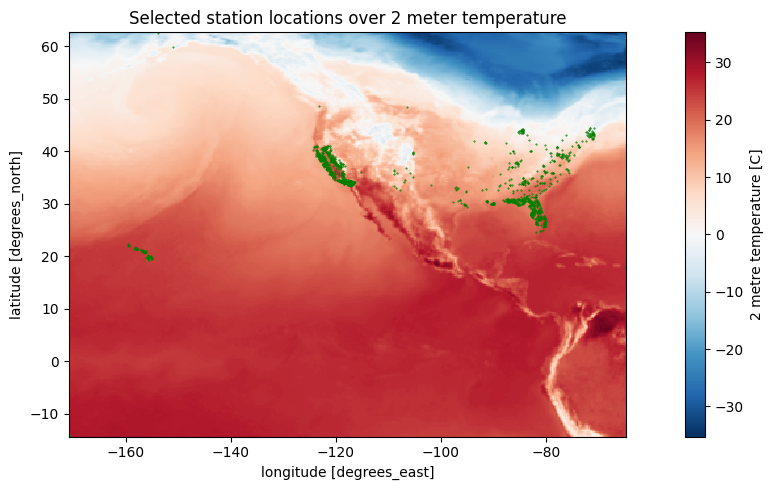

In [14]:
# Plot the locations of the stations we have on top of 2 meter temperature for context

fig, ax = plt.subplots(figsize=(12, 5))

min_lng, min_lat, max_lng, max_lat = stations_df.total_bounds
(
    gefs_ds["temperature_2m_avg"]
    .sel(longitude=slice(min_lng, max_lng), latitude=slice(max_lat, min_lat))
    .sel(init_time=start_time_utc, lead_time="0h", method="nearest")
    .plot(ax=ax)
)
stations_df.plot(c="green", markersize=0.2, ax=ax)
ax.set_title("Selected station locations over 2 meter temperature")
plt.tight_layout()

In [ ]:
# The xvec library makes it easy to extract out thousands of points or compute zonal statistics
stations_gefs_ds = gefs_ds.xvec.extract_points(
    stations_df.geometry, x_coords="longitude", y_coords="latitude", name="station"
)
# Add the station id and name as coordinate labels along the station dimension of our GEFS dataset
stations_gefs_ds = stations_gefs_ds.assign_coords(
    station_id=("station", stations_df["stationIdentifier"]),
    station_name=("station", stations_df["name"])
)
stations_gefs_ds

Text(0.5, 1.0, 'Ensemble mean precipitation forecasts at 1500 weather stations')

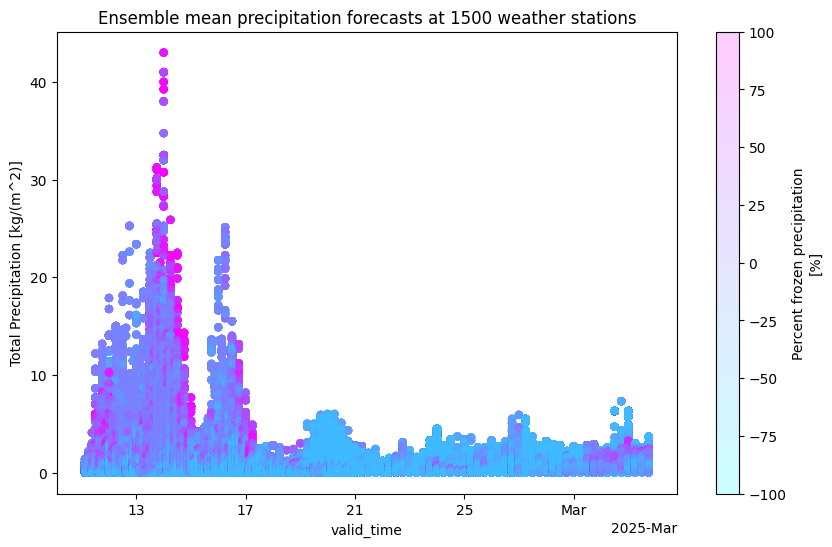

In [10]:
# Make a precipitation forecast scatter plot with forecasts from every station.
# Color the dots by rain or not rain.
(
    stations_gefs_ds
    .sel(init_time="2025-02-11T00")
    .sel(lead_time=slice("0h", "20d"))
).plot.scatter(
    x="valid_time",
    y="precipitation_surface_avg",
    hue="percent_frozen_precipitation_surface",
    cmap="cool",
    alpha=0.2,
    linewidths=0,
    figsize=(10, 6),
)
plt.title(f"Ensemble mean precipitation forecasts at {len(stations_gefs_ds.station)} weather stations")

In [11]:
# Create a table of stations sorted by the ensemble average precipitation
# accumulation forecast for the first 48 hours of the selected forecast
(
    stations_gefs_ds["precipitation_surface_avg"]
    .sel(init_time=start_time_utc, method="nearest")
    .sel(lead_time=stations_gefs_ds.lead_time < pd.Timedelta(hours=48))
    .sum(dim="lead_time")  # accumulate precipitation
    .to_dataframe()
    .sort_values("precipitation_surface_avg", ascending=False)
    [["station_id", "station_name", "precipitation_surface_avg"]]
)

,station_id,station_name,precipitation_surface_avg
station,,,
POINT (-91.4036 32.7032),143BX,143B Pioneer,124.550781
POINT (-92.06999 32.59848),1315W,Ouachita Christian School,118.447266
POINT (-88.81916 33.4445),2093W,Starkville Academy,93.597656
POINT (-88.79258 33.4572),2091W,Mississippi State University,93.597656
POINT (-86.55164 34.6961),1575W,Randolph School,78.005615
...,...,...,...
POINT (-122.39539 40.48043),103PG,Kiwi Lane,0.000000
POINT (-121.88686 39.83897),237PG,Camenzind Court,0.000000
POINT (-120.66758 38.56751),240PG,Mine Road,0.000000
